In [1]:
import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, FuncFormatter

def log_format_func(value, pos):
    """Format the log ticks as 10^x with fractional powers."""
    exponent = np.log10(value)
    return f"$10^{{{exponent:.1f}}}$"  # LaTeX-style formatting

In [2]:
functions_to_call = [
    "rfsf_trp", "rfsf_cs", "rfsf_dp2", "rfsf_dp1",
    "lifted_kt", "lifted_pde", "sigkerax"
]

In [3]:
renamed_functions = [
    "RFSF-TRP", "RFSF-TS", "RFSF-DP", "RFSF-DP-1D",
    "KSig", "KSigPDE", "Sigkerax"
]

In [4]:
L = [int(10 ** x) for x in np.linspace(2, 6, num=4*5 + 1)]

In [5]:
with open("../sauron_results_3/sequence_length_time/brownian.pkl", "rb") as f:
    time_measurements = pickle.load(f)

with open("../sauron_results_3/sequence_length_time/brownian_sigkerax.pkl", "rb") as f:
    time_measurements.update(pickle.load(f))

In [6]:
with open("../sauron_results_3/sequence_length_memory/brownian.pkl", "rb") as f:
    memory_measurements = pickle.load(f)

with open("../sauron_results_3/sequence_length_memory/brownian_sigkerax.pkl", "rb") as f:
    memory_measurements.update(pickle.load(f))

## Runtime

In [7]:
cpu_time_results = []
gpu_time_results = []
for i, l in enumerate(L):
    cpu_row = []
    gpu_row = []
    for j, name in enumerate(functions_to_call):
        cpu_times = time_measurements[("cpu", name, l)]
        if None in cpu_times:
            output = np.nan
        else:
            # Seems to be ms
            # output = sum(cpu_times[1:]) / (len(cpu_times) - 1) / 1e3
            output = np.median(cpu_times[1:])
        cpu_row.append(output)

        gpu_times = time_measurements[("gpu", name, l)]
        if None in gpu_times:
            output = np.nan
        else:
            # output = sum(gpu_times[1:]) / (len(gpu_times) - 1)
            output = np.median(gpu_times[1:])
        gpu_row.append(output)

    cpu_time_results.append(cpu_row)
    gpu_time_results.append(gpu_row)

In [8]:
cpu_time_df = pd.DataFrame(cpu_time_results, index = L, columns=renamed_functions).round(3)

In [9]:
gpu_time_df = pd.DataFrame(gpu_time_results, index = L, columns=renamed_functions).round(3)

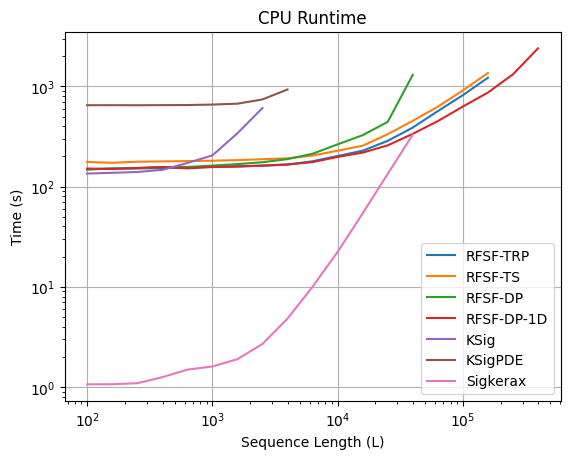

In [10]:
cpu_time_df.plot()
plt.loglog()
plt.xlabel(r"Sequence Length (L)")
plt.ylabel(r"Time (s)")
plt.title("CPU Runtime")
plt.grid()

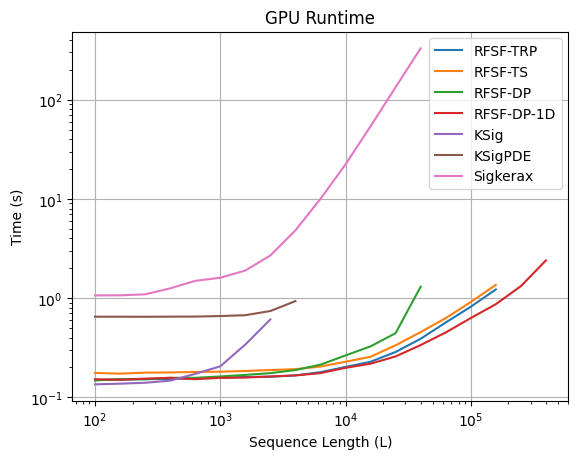

In [11]:
gpu_time_df.plot()
plt.loglog()
plt.xlabel(r"Sequence Length (L)")
plt.ylabel(r"Time (s)")
plt.title("GPU Runtime")
plt.grid()

## Memory

In [12]:
cpu_memory_results = []
gpu_memory_results = []
for i, l in enumerate(L):
    cpu_row = []
    gpu_row = []
    for j, name in enumerate(functions_to_call):
        # cpu_current, cpu_peak, gpu_current, gpu_peak
        memory = memory_measurements[(name, l)]
        if memory in [None, "Timeout"]:
            cpu_output = np.nan
            gpu_output = np.nan
        else:
            # cpu_peak
            cpu_output = memory[1] / 1e6
            # used_bytes
            gpu_output = memory[3] / 1e6
        cpu_row.append(cpu_output)
        gpu_row.append(gpu_output)
    cpu_memory_results.append(cpu_row)
    gpu_memory_results.append(gpu_row)

In [13]:
cpu_memory_df = pd.DataFrame(cpu_memory_results, index = L, columns=renamed_functions).round(3)

In [14]:
gpu_memory_df = pd.DataFrame(gpu_memory_results, index = L, columns=renamed_functions).round(3)

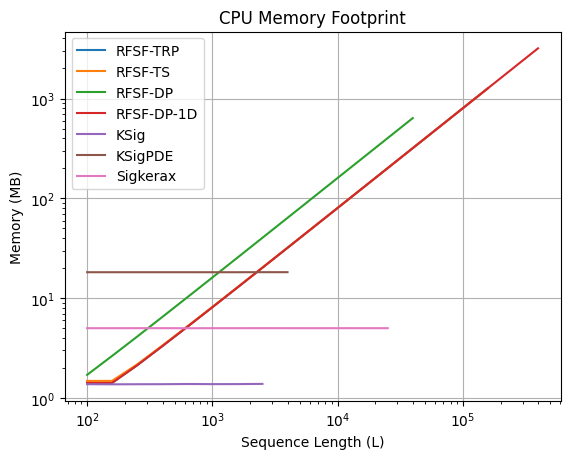

In [15]:
cpu_memory_df.plot()
plt.loglog()
plt.xlabel(r"Sequence Length (L)")
plt.ylabel(r"Memory (MB)")
plt.title("CPU Memory Footprint")
plt.grid()

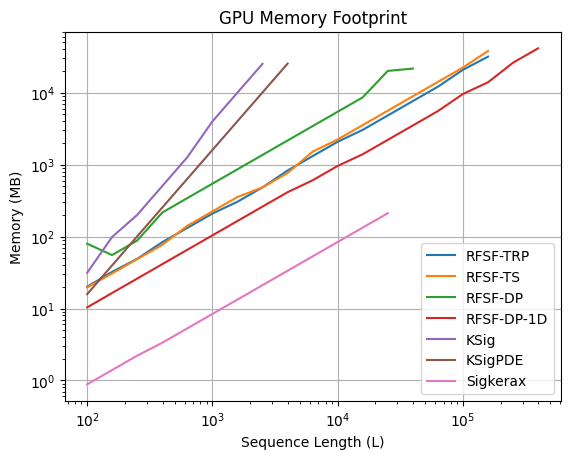

In [16]:
gpu_memory_df.plot()
plt.loglog()
plt.xlabel(r"Sequence Length (L)")
plt.ylabel(r"Memory (MB)")
plt.title("GPU Memory Footprint")
plt.grid()


## Plots

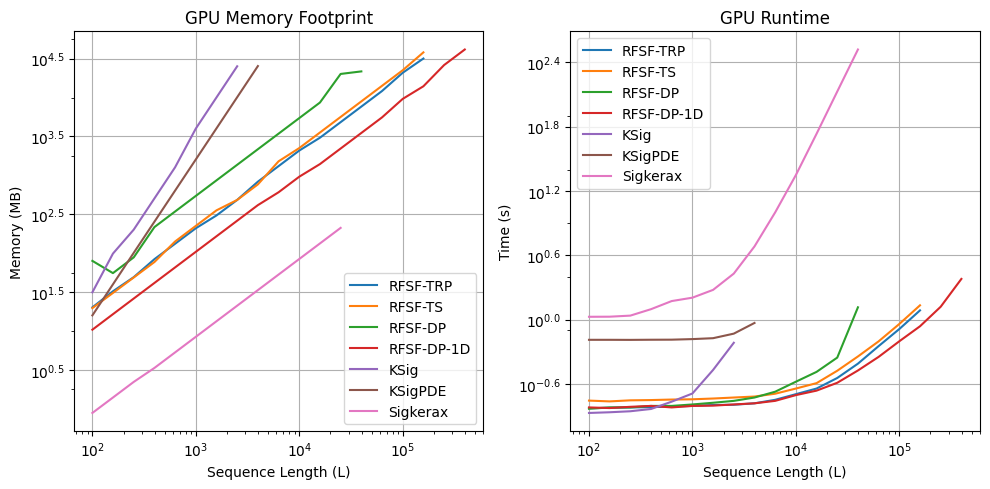

In [17]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax_ = ax[0]
gpu_memory_df.plot(ax=ax_)
ax_.loglog()

ax_.yaxis.set_major_locator(LogLocator(base=10**0.5))
ax_.yaxis.set_major_formatter(FuncFormatter(log_format_func))
ax_.yaxis.set_minor_locator(LogLocator(base=10**0.25))
ax_.yaxis.set_minor_formatter("")

ax_.set_xlabel(r"Sequence Length (L)")
ax_.set_ylabel(r"Memory (MB)")
ax_.set_title("GPU Memory Footprint")
ax_.grid()

ax_ = ax[1]
gpu_time_df.plot(ax=ax_)
ax_.loglog()

ax_.yaxis.set_major_locator(LogLocator(base=10**0.2))
ax_.yaxis.set_major_formatter(FuncFormatter(log_format_func))
ax_.yaxis.set_minor_locator(LogLocator(base=10**0.1))
ax_.yaxis.set_minor_formatter("")

ax_.set_xlabel(r"Sequence Length (L)")
ax_.set_ylabel(r"Time (s)")
ax_.set_title("GPU Runtime")
ax_.grid()

plt.tight_layout()
plt.savefig("sequence_length_resources.pdf")